#### July 21, 2022
### HMDA analysis via:
#### Source: 2021 National Loan Level Dataset from the Consumer Financial Protection Bureau of the  Federal Financial Institution Examination Council, per the Home Mortgage Disclosure Act of 1975
https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2021)



helpful source from medium: https://imitra14.medium.com/racial-discrimination-in-the-mortgage-market-insights-from-data-ba24d5f0bacf

background info from NCRC: 
(1) https://www.ncrc.org/initial-analysis-of-2021-hmda-data-the-year-that-homes-became-atms-again/
(2) https://ncrc.org/2020-hmda-preliminary-analysis/



#### deep dive report: https://files.consumerfinance.gov/f/documents/cfpb_new-revised-data-points-in-hmda_report.pdf
#### understanding a covered loan, and the scope of transaction data: https://files.consumerfinance.gov/f/documents/cfpb_2022-hmda-transactional-coverage.pdf
#### brief from Urban https://www.urban.org/urban-wire/what-different-denial-rates-can-tell-us-about-racial-disparities-mortgage-market

*Very interesting ML project on approvals/denials by race and other characteristics: https://q-shick.github.io/portfolio/proj_hmda.html

In [846]:
import numpy as np
import pandas as pd
import re
import random
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)
import os
os. getcwd()
os.chdir('/Users/trevor.mattos/Desktop/nycdsa/Python/PythonProject1')


#### Read in a 1 percent sample of the 26 million HMDA records
code from: https://www.kaggle.com/questions-and-answers/53925

In [323]:
# read in 1 percent sample
df=pd.read_csv("2021_public_lar.csv", 
               header=None,
                    skiprows = lambda i: random.random() >0.01)

In [781]:
# read in a separate dataframe to get the headers
df_cols = pd.read_csv("2021_public_lar.csv", header=None, nrows = 1)
# concatenate the new headers and the data
df1=pd.concat([df_cols, df], axis = 0)
# set first row as column headers and name df2
df2=df1.rename(columns=df1.iloc[0]).drop(df1.index[0])

### Data cleaning:

In [782]:
# remove 'exempt' from property_value (assign np.nan)
df2.loc[df2['property_value']=='Exempt', 'property_value']=np.nan

# create binary variable for loan denied
df2['denied']=np.where(df2['action_taken']==3,1,0)

# recast loan amount as numeric
df2['loan_amount']=pd.to_numeric(df2.loan_amount)

#recast property_value as numeric
df2['property_value']=pd.to_numeric(df2.property_value)

#recast income to numeric and change metric to dollars (instead of thousands of dollars)
df2['income']=pd.to_numeric(df2.income)
df2['income']=df2['income']*1000 # put in thousands

# recast interest rate and set exempt values to NA
df2.loc[df2['interest_rate']=='Exempt', 'interest_rate']=np.nan
df2['interest_rate']=pd.to_numeric(df2['interest_rate'])

# recast total loan costs and set exempt values to NA
df2.loc[df2['total_loan_costs']=='Exempt', 'total_loan_costs']=np.nan
df2['total_loan_costs']=pd.to_numeric(df2['total_loan_costs'])

# recast loan to value ratio as numeric
df2.loc[df2['combined_loan_to_value_ratio']=='Exempt', 'combined_loan_to_value_ratio']=np.nan
df2['combined_loan_to_value_ratio']= pd.to_numeric(df2['combined_loan_to_value_ratio'])

# dummy var for single family home
df2['singlefam']=np.where(df2['derived_dwelling_category']==('Single Family (1-4 Units):Site-Built' or 'Single Family (1-4 Units):Manufactured'),1,0)

# recode occupancy type with meaninful string values
df2['occupancy_type'] = df2['occupancy_type'].replace(
    [1,2,3],['primary residence','second residence','investment property'])

#remove free form race entries (drop these rows)
df2 = df2[df2.derived_race != 'Free Form Text Only']

#remove free form ethnicity entries (drop these rows)
df2 = df2[df2.derived_ethnicity != 'Free Form Text Only']


In [836]:
# cross tabulate race and ethnicity to help in recoding
#pd.crosstab(df2.derived_race, df2.derived_ethnicity, dropna=False)

In [807]:
# create function to recode race and ethnicity into one merged variable
def racegroups(df):
    if (df['derived_race']=='White') and (df['derived_ethnicity'] =='Not Hispanic or Latino'):
        return 'White'
    elif ((df['derived_race']=='Race Not Available') and ((df['derived_ethnicity'] == 'Not Hispanic or Latino') or (df['derived_ethnicity'] == 'Ethnicity Not Available' ))) or (df['derived_ethnicity'] == 'Ethnicity Not Available'):
        return 'Race or Ethnicity Not Available'
    elif (df['derived_race']=='Black or African American') and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Black or African American'
    elif ((df['derived_race']=='Asian') or (df['derived_race']=='Native Hawaiian or Other Pacific Islander'))  and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'AAPI' 
    elif ((df['derived_race']=='Joint') or (df['derived_race']=='2 or more minority races')) and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Multiracial'
    elif (df['derived_race']=='American Indian or Alaska Native') and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Native American'
    elif (df['derived_ethnicity'] == 'Hispanic or Latino') or (df['derived_ethnicity'] == 'Joint') :
        return 'Hispanic or Latino'
    #elif (df['derived_ethnicity'] == 'Ethnicity Not Available'):
        #return 'Ethnicity Not Available'
    
#use racegroups function to create newrace variable
df2['newrace'] = df2.apply(racegroups, axis=1)

In [329]:
# drop naN in loan_amount
#df2['property_value'] = df2[df2['property_value'].notna()]
#df2['property_value']=df2.property_value.astype(int)
#df2.property_value
#df2.loan_amount

In [ ]:
# remove outliers from loan amount
#df3 = df2[(df2['loan_amount'] <= df2['loan_amount'].mean()+(3*(df2['loan_amount'])))]

In [783]:
#recode debt_to_income_ratio so that groupings are somewhat comparable
# bucket all 30-39%
df2['debt_to_income_ratio'].replace('^3.*','30%-39%', regex=True, inplace=True)
# bucket all 40-49%
df2['debt_to_income_ratio'].replace('^4.*','40%-49%', regex=True, inplace=True)
df2['debt_to_income_ratio'].value_counts()

30%-39%     49747
40%-49%     48905
20%-<30%    35783
<20%        16927
50%-60%      8700
>60%         6484
Exempt       3562
Name: debt_to_income_ratio, dtype: int64

### Data exploration and visualization:

In [842]:
#df2.groupby('newrace').agg({'income': 'median', 'denied': 'mean'})

In [831]:
#plt.hist(df2['loan_amount'], log=True, bins=250, color="#5ee3ff")
#plt.title('loan_amount', fontsize = 20)

In [832]:
#plt.hist(np.log(df2['property_value']), bins=200, color="#5ee3ff")
#plt.title('property value', fontsize = 20)
#plt.xlim( [ 0, 10000000 ] )


#plt.hist(np.log(df['budget'].dropna()), bins = 100, color = "#5ee3ff")


In [833]:

#df2.plot(kind = 'scatter',x = 'loan_amount', y = 'income', alpha=.3)

#plt.xlabel('loan amount')
#plt.ylabel('income')
#plt.title('loan vs income')

In [ ]:
# begin with some overview stuff

    # What is the total number of loan transactions? 
    # Roughly what percentage of all loans does the dataset include? 
    # What is the distribution by type of dwelling? Use the sample.
    # occupancy_type (dwelling, rented, etc)
    # What are the race, sex, ethnicity distributions of applicants?
    # Overall, what are the share of applicants by action taken?
    # Interesting question: is there a correlation between those who request preapproval and those who are approved?
    # Distribution of loan amount
    # Median loan amount by race, gender, ethnicity
    # Average interest rate by race, gender, ethnicity 
    # HOEPA status by race, gender, ethnicity
    # Total loan costs by race, gender, ethnicity
    # property value by race, gender, ethnicity
    # income and debt to income ratio
    #combined loan to value ratio
    # denial reasons by race, gender, ethnicity

In [834]:
# examine data and check data types

df2['derived_dwelling_category'].value_counts()
df2['occupancy_type'].value_counts()
df2['derived_sex'].value_counts()
df2['derived_ethnicity'].value_counts()
df2['derived_race'].value_counts()
df2['loan_amount'] # currently an integer
df2['interest_rate'] # currently float
df2['hoepa_status'].value_counts()
df2['total_loan_costs'] # currently a float
df2['property_value']
df2['debt_to_income_ratio']
df2['income']
df2['denial_reason_1'].value_counts() # code 1111 is exempt, per https://files.consumerfinance.gov/f/documents/201710_cfpb_reportable-hmda-data_regulatory-and-reporting-overview-reference-chart.pdf


10      227776
1         8348
3         7355
7         4477
4         3487
9         3037
1111      2809
6         1548
5          622
2          449
8           11
Name: denial_reason_1, dtype: int64

### Consider using plotly for final visualizations to improve final blog aesthetics

In [584]:
# plotly graphs


In [835]:
# df2['newrace'].value_counts().sort_values(ascending=False).plot.bar()
# plt.xlabel('Race of loan applicant')
# plt.ylabel('Count')
# plt.title('Loan application by race')

Text(0.5, 1.0, 'Loan application by occupancy type')

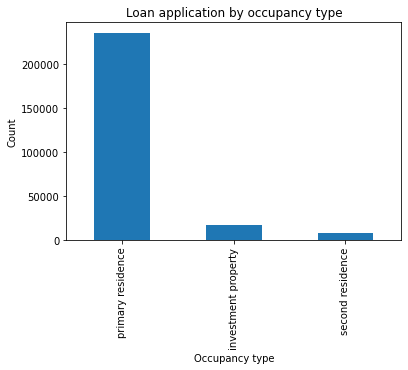

In [811]:
df2['occupancy_type'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Occupancy type')
plt.ylabel('Count')
plt.title('Loan application by occupancy type')

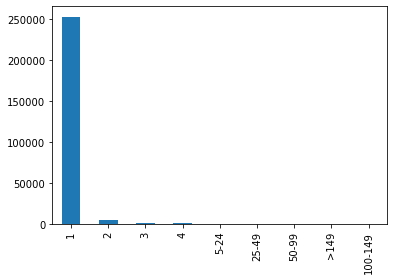

In [812]:
df2['total_units'].value_counts().sort_values(ascending=False).plot.bar()

In [844]:
# calculate share of applicants by race and plot in next cell
racedf=df2.groupby('newrace')[['newrace']].agg('count')/(df2.derived_race.count())*100
racedf=racedf.rename(columns={'newrace':'raceshare'})


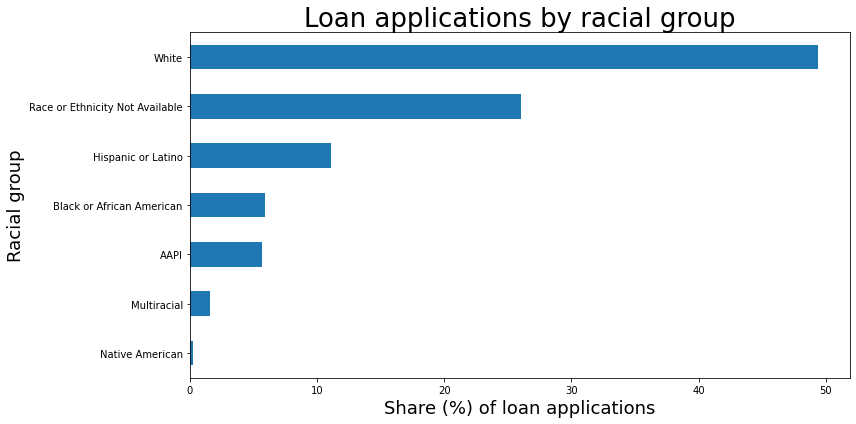

In [825]:
plt.figure(figsize = (12,6))
racedf['raceshare'].sort_values(ascending=True).plot.barh()
plt.xlabel('Share (%) of loan applications', fontsize=18)
plt.ylabel('Racial group', fontsize=18)
plt.title('Loan applications by racial group', fontsize=26)

plt.tight_layout()
plt.savefig("graph1.jpg", dpi=250)

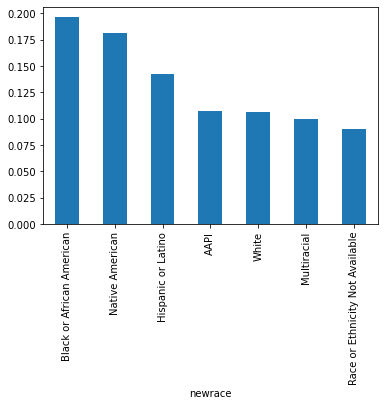

In [845]:
df2.groupby('newrace')['denied'].mean().sort_values(ascending=False).plot.bar()